In [ ]:
# !wget -c "http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv"
# !wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
# !wget -c "http://nlp.stanford.edu/data/glove.twitter.27B.zip"
# !wget -c "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz"
# !unzip -o glove.twitter.27B.zip

--2023-11-13 16:12:09--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.32.200, 52.217.123.136, 52.216.38.104, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.32.200|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-11-13 16:12:09 ERROR 404: Not Found.



In [ ]:
# !pip3 install -U sentence-transformers
# !pip3 install --upgrade Gensim
# !pip3 install fuzzywuzzy
# !pip3 install --upgrade networkx
# !pip3 install imblearn

In [ ]:
import pandas as pd
import numpy as np
import scipy
import re
import hashlib
from fuzzywuzzy import fuzz
from IPython.display import display
from collections import defaultdict
from matplotlib import pyplot
import networkx as nx
import time
import sys
from functools import reduce

ModuleNotFoundError: ignored

In [ ]:
train_dataset = pd.read_csv('quora_duplicate_questions.tsv', delimiter='\t').dropna(how='any').reset_index(drop=True)

In [ ]:
train_dataset.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## Data Preprocessing

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import SnowballStemmer

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1122)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1122)>


False

In [ ]:
train_dataset = train_dataset.drop(['id','qid1','qid2'],axis=1)

In [ ]:
train_dataset = train_dataset.fillna("")

<Axes: xlabel='is_duplicate'>

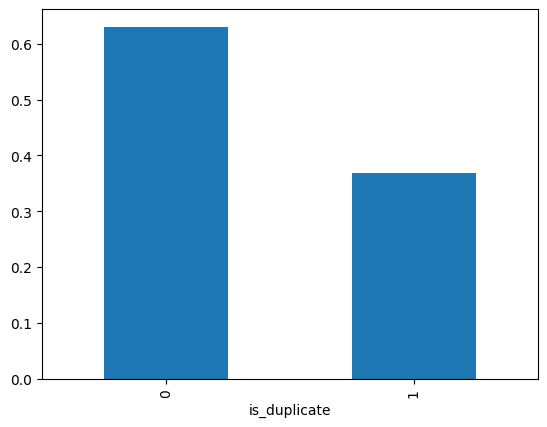

In [ ]:
train_dataset['is_duplicate'].value_counts(normalize=True).plot.bar()

In [ ]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def preprocessing_text( txt):
        txt = txt.lower()
        txt = txt.replace(',000,000', 'm').replace(',000', 'k'
                ).replace('\xe2\x80\xb2', "'").replace('\xe2\x80\x99',
                "'").replace("can't", 'cannot').replace("don't",
                'do not').replace("isn't", 'is not').replace("you're",
                'you are').replace("you've", 'you have'
                                   ).replace("you'll", 'you will'
                ).replace("that'll", 'that will').replace("should've",
                'should have').replace("aren't", 'are not'
                ).replace("couldn't", 'could not').replace("didn't",
                'did not').replace("doesn't", 'does not'
                                   ).replace("hadn't", 'had not'
                ).replace("hasn't", 'has not').replace("haven't",
                'have not').replace("mustn't", 'must not'
                                    ).replace("wasn't", 'was not'
                ).replace("i'm", 'i am').replace("he's", 'he is'
                ).replace("she's", 'she is').replace("ain't", 'am not'
                ).replace('%', ' percent ').replace('\xe2\x82\xb9',
                ' rupee ').replace('$', ' dollar '
                                   ).replace('\xe2\x82\xac', ' euro '
                ).replace("'ll", ' will').replace("'ve", ' have'
                ).replace("it's", 'it is')

        txt = re.sub(r"[^A-Za-z0-9(),!.?\'\`]", ' ', txt)
        txt = re.sub(r"\'s", " 's ", txt)
        txt = re.sub(r"\'ve", " 've ", txt)
        txt = re.sub(r"n\'t", " 't ", txt)
        txt = re.sub(r"\'re", " 're ", txt)
        txt = re.sub(r"\'d", " 'd ", txt)
        txt = re.sub(r"\'ll", " 'll ", txt)
        txt = re.sub(r",", ' ', txt)
        txt = re.sub(r"\.", ' ', txt)
        txt = re.sub(r"!", ' ', txt)
        txt = re.sub(r"\(", ' ( ', txt)
        txt = re.sub(r"\)", ' ) ', txt)
        txt = re.sub(r"\?", ' ', txt)
        txt = re.sub(r"\s{2,}", ' ', txt)
        text_tokens = word_tokenize(txt)
        tokens_without_sw = [word for word in text_tokens if word not
                             in stop_words and len(word) != 1]
        # txt = ' '.join(tokens_without_sw)
        # txt = stemmer.stem(txt)


        # Lemmatize
        lemmatizer = WordNetLemmatizer()
        lemmatized_tokens = [lemmatizer.lemmatize(w) for w in tokens_without_sw]

        # Reconstruct the text from tokens
        processed_text = ' '.join(lemmatized_tokens)

        return txt

In [ ]:
train_dataset['question1_clean'] = train_dataset['question1'].apply(preprocessing_text)
train_dataset['question2_clean'] = train_dataset['question2'].apply(preprocessing_text)


In [ ]:
train_dataset.head()

,question1,question2,is_duplicate,question1_clean,question2_clean
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,step step guide invest share market india,step step guide invest share market
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,increase speed internet connection using vpn,internet speed increased hacking dn
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,mentally lonely solv,find remainder math 23 24 math divided 24 23
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,one dissolve water quikly sugar salt methane c...,fish would survive salt wat


## Feature Extraction

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import Birch
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis


In [ ]:
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.fasttext import load_facebook_model

In [ ]:
SAFE_DIV = 0.0001
NB_CORES = 10
FREQ_UPPER_BOUND = 100
NEIGHBOR_UPPER_BOUND = 5
MAX_ITER = 20
WORD2VEC_MODELS = [['GoogleNews-vectors-negative300.bin.gz',
                   '_word2vec_googlenews', '_clean', True], ['glove.txt'
                   , '_glove', '_clean', False]]

In [ ]:
def get_nlp_features(data):
        q1_tokens = str(data["question1"]).split()
        q2_tokens = str(data["question2"]).split()
        q1_words = set([word for word in q1_tokens if word
                       not in stop_words])
        q2_words = set([word for word in q2_tokens if word
                       not in stop_words])
        q1_stops = set([word for word in q1_tokens if word
                       not in stop_words])
        q2_stops = set([word for word in q2_tokens if word
                       in stop_words])
        common_word_count = len(q1_words.intersection(q2_words))
        common_stop_count = len(q1_stops.intersection(q2_stops))
        common_token_count = \
            len(set(q1_tokens).intersection(set(q2_tokens)))
        data['len_q1'] = np.nan_to_num(data["question1"].apply(lambda x: \
                len(str(x))))
        data['len_q2'] = np.nan_to_num(data["question2"].apply(lambda x: \
                len(str(x))))
        data['diff_len'] = np.nan_to_num(data.len_q1 - data.len_q2)
        data['len_char_q1'] = \
            np.nan_to_num(data["question1"].apply(lambda x: \
                          len(''.join(set(str(x).replace(' ', ''))))))
        data['len_char_q2'] = \
            np.nan_to_num(data["question2"].apply(lambda x: \
                          len(''.join(set(str(x).replace(' ', ''))))))
        data['len_word_q1'] = \
            np.nan_to_num(data["question1"].apply(lambda x: \
                          len(str(x).split())))
        data['len_word_q2'] = \
            np.nan_to_num(data["question2"].apply(lambda x: \
                          len(str(x).split())))
        data['cwc_min'] = np.nan_to_num(common_word_count
                / (min(len(q1_words), len(q2_words)) + SAFE_DIV))
        data['cwc_max'] = np.nan_to_num(common_word_count
                / (max(len(q1_words), len(q2_words)) + SAFE_DIV))
        data['csc_min'] = np.nan_to_num(common_stop_count
                / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV))
        data['csc_max'] = np.nan_to_num(common_stop_count
                / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV))
        data['ctc_min'] = np.nan_to_num(common_token_count
                / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV))
        data['ctc_max'] = np.nan_to_num(common_token_count
                / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV))
        data['last_word_eq'] = np.nan_to_num(int(q1_tokens[-1]
                == q2_tokens[-1]))
        data['first_word_eq'] = np.nan_to_num(int(q1_tokens[0]
                == q2_tokens[0]))
        data['abs_len_diff'] = np.nan_to_num(abs(len(q1_tokens)
                - len(q2_tokens)))
        data['mean_len'] = np.nan_to_num((len(q1_tokens)
                + len(q2_tokens)) / 2)
        return data

In [ ]:
def get_fuzzy_features(data):
        data['fuzz_ratio'] = np.nan_to_num(data.apply(lambda x: \
                fuzz.ratio(str(x['question1']), str(x['question2'])),
                axis=1))
        data['fuzz_partial_ratio'] = np.nan_to_num(data.apply(lambda x: \
                fuzz.partial_ratio(str(x['question1']),
                str(x['question2'])), axis=1))
        data['fuzz_partial_token_set_ratio'] = \
            np.nan_to_num(data.apply(lambda x: \
                          fuzz.partial_token_set_ratio(str(x['question1'
                          ]), str(x['question2'])), axis=1))
        data['fuzz_partial_token_sort_ratio'] = \
            np.nan_to_num(data.apply(lambda x: \
                          fuzz.partial_token_sort_ratio(str(x['question1'
                          ]), str(x['question2'])), axis=1))
        data['fuzz_token_set_ratio'] = \
            np.nan_to_num(data.apply(lambda x: \
                          fuzz.token_set_ratio(str(x['question1']),
                          str(x['question2'])), axis=1))
        data['fuzz_token_sort_ratio'] = \
            np.nan_to_num(data.apply(lambda x: \
                          fuzz.token_sort_ratio(str(x['question1']),
                          str(x['question2'])), axis=1))
        return data

In [ ]:
train_dataset = get_nlp_features(train_dataset)
train_dataset.head()

,question1,question2,is_duplicate,question1_clean,question2_clean,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,...,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,step step guide invest share market india,step step guide invest share market,66,57,9,20,20,...,0.559321,0.549999,0.0,0.0,0.46875,0.441176,1,1,6,99.0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...,51,88,-37,21,29,...,0.559321,0.549999,0.0,0.0,0.46875,0.441176,1,1,6,99.0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,increase speed internet connection using vpn,internet speed increased hacking dn,73,59,14,25,24,...,0.559321,0.549999,0.0,0.0,0.46875,0.441176,1,1,6,99.0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,mentally lonely solv,find remainder math 23 24 math divided 24 23,50,65,-15,19,26,...,0.559321,0.549999,0.0,0.0,0.46875,0.441176,1,1,6,99.0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,one dissolve water quikly sugar salt methane c...,fish would survive salt wat,76,39,37,25,18,...,0.559321,0.549999,0.0,0.0,0.46875,0.441176,1,1,6,99.0


## Model training

In [ ]:
!pip3 install xgboost

     |████████████████████████████████| 2.2 MB 4.3 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
model = XGBClassifier( max_depth=80, n_estimators=100,learning_rate=0.1, colsample_bytree=.7,gamma=0, reg_alpha=4,objective='binary:logistic',eta=0.3,silent=1,verbosity=0)

In [ ]:
train_dataset.head()

,question1,question2,is_duplicate,question1_clean,question2_clean,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,...,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,step step guide invest share market india,step step guide invest share market,66,57,9,20,20,...,0.549999,0.0,0.0,0.46875,0.441176,1,1,6,99.0,93
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...,51,88,-37,21,29,...,0.549999,0.0,0.0,0.46875,0.441176,1,1,6,99.0,65
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,increase speed internet connection using vpn,internet speed increased hacking dn,73,59,14,25,24,...,0.549999,0.0,0.0,0.46875,0.441176,1,1,6,99.0,45
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,mentally lonely solv,find remainder math 23 24 math divided 24 23,50,65,-15,19,26,...,0.549999,0.0,0.0,0.46875,0.441176,1,1,6,99.0,7
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,one dissolve water quikly sugar salt methane c...,fish would survive salt wat,76,39,37,25,18,...,0.549999,0.0,0.0,0.46875,0.441176,1,1,6,99.0,37


In [ ]:

def preprocess(train_dataset):
    train_dataset.drop(['question1', 'question2', 'question1_clean', 'question2_clean'], axis=1, inplace=True)
    X = train_dataset.loc[:, train_dataset.columns != 'is_duplicate']
    Y = np.array(train_dataset.loc[:, train_dataset.columns == 'is_duplicate']).ravel()
    return X, Y

def report_average(reports_list, iter):
    metrics_0 = [0] * 4
    metrics_1 = [0] * 4
    accuracy = [0] * 2
    macro = [0] * 4
    weighted = [0] * 4
    for report in reports_list:
        splited = [' '.join(x.split()) for x in report.split('\n\n')]
        metrics = np.array(splited[1].split(' '))
        metrics_0 = metrics_0 + np.nan_to_num(np.array([metrics[1], metrics[2], metrics[3], metrics[4]]).astype(float))
        metrics_1 = metrics_1 + np.nan_to_num(np.array([metrics[6], metrics[7], metrics[8], metrics[9]]).astype(float))
        totals = np.array([x for x in splited[2].split(' ')])
        accuracy = accuracy + np.nan_to_num(np.array([totals[1], totals[2]]).astype(np.float32))
        macro = macro + np.nan_to_num(np.array([totals[5], totals[6], totals[7], totals[8]]).astype(float))
        weighted = weighted + np.nan_to_num(np.array([totals[11], totals[12], totals[13], totals[14]]).astype(float))
    metrics_0 = metrics_0 / iter
    metrics_1 = metrics_1 / iter
    accuracy = accuracy / iter
    macro = macro / iter
    weighted = weighted / iter
    header = [x for x in splited[0].split(' ')]
    print('{:<20} {:<20} {:<20} {:<20} {:<20}'.format('', header[0], header[1], header[2], header[3]))
    print('{:<20} {:<20} {:<20} {:<20} {:<20}'.format('0', metrics_0[0], metrics_0[1], metrics_0[2], metrics_0[3]))
    print('{:<20} {:<20} {:<20} {:<20} {:<20}'.format('1', metrics_1[0], metrics_1[1], metrics_1[2], metrics_1[3]))
    print('{:<20} {:<20} {:<20} {:<20} {:<20}'.format('Accuracy', '', '', accuracy[0], accuracy[1]))
    print('{:<20} {:<20} {:<20} {:<20} {:<20}'.format('macro avg', macro[0], macro[1], macro[2], macro[3]))
    print('{:<20} {:<20} {:<20} {:<20} {:<20}'.format('weighted avg', weighted[0], weighted[1], weighted[2], weighted[3]))

def train_models(train_dataset, iter):
    output_models = []
    X, Y = preprocess(train_dataset)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

    classif_reports = []
    for i in range(iter):
        model_out = model.fit(X_train, y_train)
        y_pred = model_out.predict(X_test)
        classif_reports.append(classification_report(y_test, y_pred))
    report_average(classif_reports, iter)

    return model_out

model = train_models(train_dataset, 10)


                     precision            recall               f1-score             support             
0                    0.7699999999999999   0.79                 0.7800000000000001   25513.0             
1                    0.62                 0.5999999999999999   0.6100000000000001   14916.0             
Accuracy                                                       0.7200000286102295   40429.0             
macro avg            0.7000000000000001   0.6899999999999998   0.6899999999999998   40429.0             
weighted avg         0.7199999999999999   0.7199999999999999   0.7199999999999999   40429.0             
